# EXPLORATORY DATA ANALYSIS // RICHMOND (NSW)
---

5th Movember 2015<br>
Andre Trosky<br>
andretrosky@gmail.com

# EXECUTIVE SUMMARY

This report explores and quantifies the effects of redistribution for the federal electorate of Richmond. Using the polling booth results from the 2015 NSW state election and electorate boundary GIS files from the Australian Electorate Commission (AEC), changes in the First Preference (FP) vote for The Country Labour Party (CLP), The Greens (GRN) and The Nation Party (NP) were analysed. 

Methods of analysis include plotting of booth locations in QGIS, Kernel Density Estimation for the probability distribution of FP votes and Pearson correlation for correlation of FP, booth size, longitude and latitude variables. The booth longitude/latitude coordinates were found using booth street addresses and the popular Python geocoding library, geopy. This document contains all the calculations except for the geocoding work as it was done in a previous body of work for Richmond.

Statistics used and or calculated for each party were FP% per booth and FP raw number of votes per booth.

Qualitative effects, in terms of FP% vote per booth, discovered were:
1. Increase in most likely CLP, GRN and NP FP% located at ~28, ~17% and ~42% respectively.
2. Reduction in probability of high FP% booths for GRN.
3. CLP and NP low performing FP% booths became less likely.
4. Reinforcement of dual voting behaviour of CLP FP% located at ~11% and ~28% FP%.
5. Increase in likelihood of mid range NP FP%, located at ~23% FP%.

Qualitative effects, in terms of FP raw number of votes per booth, discovered were:
1. Compared to GRN, it is now more likely for both CLP and NP to receive 250 - 750 FP raw votes per booth.
2. Both CLP and NP are now more likely to receive larger votes in the larger booths, as compared to GRN.
3. CLP and NP are less likely to get a small number of votes at each booth.
4. GRN displays little change. It's most likely vote per booth remains roughly the same. GRN votes of 550 - 700 per booth are also less likely.

Quantitatively, the change in mean FP% for each party, was found to be:
* CLP = -0.83%
* GRN = -5.49%
* NP = + 0.33%

And the change in total FP vote for each party:
* CLP = +1554
* GRN = -370.5
* NP = +3007.5

Correlation:
* A larger booth correlates most strongly with an increase in CLP FP%.
* As you move North, both CLP and NP FP% increase and have roughly the same magnitude of correlation. Whilst GRN FP% does also, it's only about a third as strong compared to the other two.
* Moving East, both CLP and GRN FP% increase whilst NP FP% displays little correlation.


The report finds that redistribution is most beneficial to NP, CLP and GRN in decreasing order, both in terms of FP% and FP raw votes per booth. NP gains double the amount of FP votes CLP does, whereas GRN actually lose 370.5 FP votes.

The limitations of this report include i) the assumption made on how to distribute FP votes to electorates when a polling booth is located near a new boundary and ii) voting behaviour in the state election is representative of federal politics and voting behaviour in 2016.

If the cost of an objection to the redistribution is low then it would be prudent to submit one, as it looks like there is a definite braching away of NP and CLP from GRN.

# INTRODUCTION
---

>The aim of this exploratory data analysis is to describe and quantify the effect of redistribution on the Richmond electorate.

The Australian Electorate Commission (AEC) is currently undergoing redistribution of all NSW federal electorates. To achieve redistribution, the AEC draws new boundaries for each electorate whilst taking into account the change in population. 

Redistribution aims to meet the following criteria [0]:
1. Each state and territory gains representation in the House of Representatives in proportion to their population.
2. There are a similar number of electors in each electorate division for a given state or territory.

Using the 2015 results from the NSW state election[1], we overlay both the old and redistributed boundaries to investigate the changes in First Preference Vote % (FP%) per voting booth. The AEC published an online media release detailing the redistribution proposal [2,3], and it was from here that one could find the actual GIS files needed for the analysis [4]. 

By mapping the state and federal electorate boundaries together one could see that the polling results from Tweed, Lismore and Ballina electorates would each play a role in the newly redistributed Richmond electorate. Very crudely speaking, each electorate contributes roughly a third to Richmond's new area.

This report focuses only on the following parties: 
1. Country Labour Party (CLP)
2. The Greens (GRN)
3. National Party of Australia (NP). 

The following statistics are investigated (what these quantities mean is explain later):

**FP% VOTING DISTRIBUTIONS**
* FP% distribution for PRE redistribution
* FP% distribution for POST redistribution
* Combined FP% PRE and POST redistribution

**FP RAW NUMBER VOTING DISTRIBUTIONS **
* FP Raw Number distribution for PRE redistribution
* FP Raw Number distribution for POST redistribution
* Combined FP Raw Number PRE and POST redistribution

** QUANTIFIED EFFECT OF REDISTRIBUTION**
* Effect on FP% 
* Effect on FP Raw Number

**CORRELATIONS**
* Correlation of Longitude, Latitude and Booth Size (total votes) on FP%


>Any objections to the AEC proposal for redistribution must be made by 6pm Friday November 2015 (AEDT).

# BOUNDARY BOOTHS
---

Some additional thought must go into how to incorporate the polling booth results for booths located near an electorate boundary. 

To this end, QGIS was used to plot booths and boundaries, if a booth was deemed 'on boundary' then its votes must be distributed to both Page and Richmond.

Here is the reasoning:

* **PRE redistribution:** polling data already contains proper handling of votes - NSWEC has already sorted data into electorates. Use as is.

* **POST redistribution:**
  1. If the booth is new, as in it used to be in Page but is now in Richmond, and booth is well within the new boundary, then include all the votes.
  2. If the booth is near a new boundary, and is either in Richmond or Page, distribute half of the votes to Richmond and Page respectively. 

Basically you want to mimic people voting at their nearest booth and take into account the new boundaries when using data from an election where old boundaries were in use.

> We have _arbitrarily_ chosen to halve the votes for boundary booths.

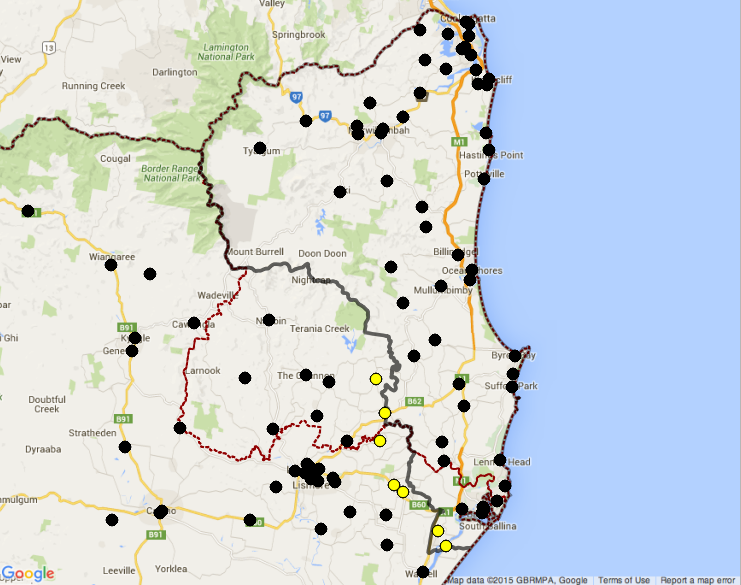

In [17]:
from IPython.display import Image
Image(filename='boundary_booths_new_boundary.png')

** Figure 1: Boundary Booths (Yellow) relevant to POST redistribution (Grey) for Richmond: ** 

* Alstonville High (now in Page)
* Clunes Public (now in Page)
* Eltham Public (now in Page)
* Empire Vale Public (now in Page)
* Pimlico Hall (now in Richmond)
* Rosebank Public (now in Page)
* Wollongbar Public (now in Page)

So we must half the contributions from the above booths to Richmond POST redistribution calculations.

> **Feel free to skip ahead. ** There is no need to read through the python code to understand the findings - it's left in here for completeness and reference only.

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pprint

#make some settings
sns.set()
pd.options.display.max_columns = 50 #try to display all of the columns when inspecting with head() etc.
pd.set_option('precision',3)

In [4]:
#use entire dataset with Page, Richmond, New England electorates 
#load in polling data for OLD distribution boundaries
richmond_redist = pd.read_excel('richmond_polling_booth_join_2.xlsx',
                                 sheetname='richmond_polling_booth_join_2')

#load in polling data for OLD distribution boundaries
richmond_predist = pd.read_excel('richmond_polling_booth_join_3_old_distribution.xlsx',
                                  sheetname='richmond_polling_booth_join_3_o')

#fix some formatting issues
richmond_redist['Venue/Decl'] = richmond_redist['Venue/Decl'].str.strip()
richmond_predist['Venue/Decl'] = richmond_predist['Venue/Decl'].str.strip()


def half_results_for_booth(data, booth, cols, dist_factor):
    data.loc[data['Venue/Decl'] == booth, cols] = data.loc[data['Venue/Decl'] == booth, cols] / dist_factor

    
boundary_booths = ['Alstonville High',
                   'Clunes Public',
                   'Eltham Public',
                   'Empire Vale Public',
                   'Pimlico Hall', #actually in Richmond
                   'Rosebank Public',
                   'Wollongbar Public']

cols_to_alter = ['Final FP V', 'Perc of total vote', 'Booth total']

for booth in boundary_booths:
    half_results_for_booth(richmond_redist, booth, cols_to_alter, 2.0)
    
def get_electorate_and_party(data, elect, party, col, redist):
    #as a result of the join, the column 'ELECT_DIV' is the correct column to sort on for electorates, not 'District'
    base_filter = (data['Party Acro'] == party)
    x = data.loc[base_filter & (data['ELECT_DIV'] == elect), col]

    if redist:
        page_booths = list(set(boundary_booths) - set(['Pimlico Hall'])) #because we already have this in x
        y = [data.loc[base_filter & (data['Venue/Decl'] == booth), col] for booth in page_booths]
        z = pd.concat(y)
        return pd.concat([x, z])
    else:
        return x


clp_redist = get_electorate_and_party(richmond_redist, 'Richmond', 'CLP', 'Perc of total vote', True)
clp_predist = get_electorate_and_party(richmond_predist, 'Richmond', 'CLP', 'Perc of total vote', False)
grn_redist = get_electorate_and_party(richmond_redist, 'Richmond', 'GRN', 'Perc of total vote', True)
grn_predist = get_electorate_and_party(richmond_predist, 'Richmond', 'GRN', 'Perc of total vote', False)
np_redist = get_electorate_and_party(richmond_redist, 'Richmond', 'NP', 'Perc of total vote', True)
np_predist = get_electorate_and_party(richmond_predist, 'Richmond', 'NP', 'Perc of total vote', False)

# BOOTH SIZE DISTRIBUTION
---

It's always good to have in the back of your mind the distribution of booth sizes for Richmond. First we plot the booth sizes for PRE, then POST redistribution.

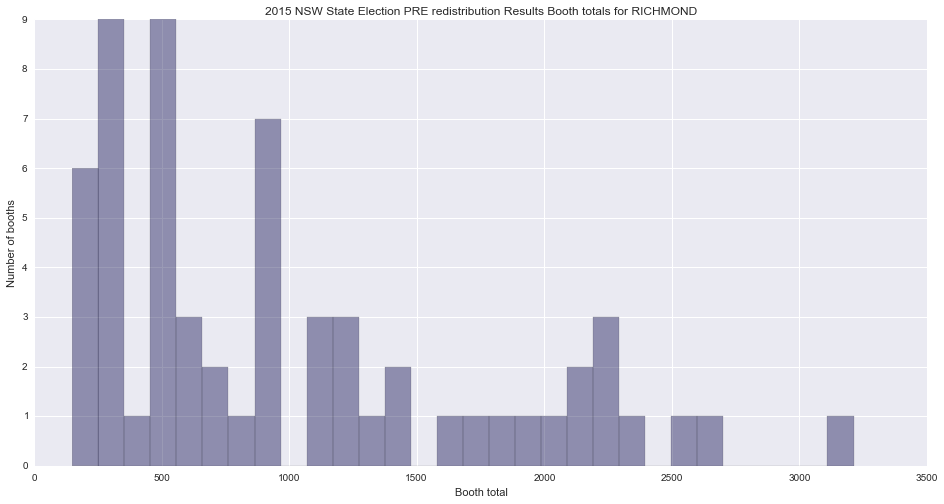

In [5]:
plt.figure(figsize=(16, 8))
sns.distplot(get_electorate_and_party(richmond_predist, 'Richmond', 'CLP', 'Booth total', False),
             bins=30, color=sns.xkcd_rgb["night blue"], label='Total Booth Vote', kde=False)

plt.xlabel('Booth total')
plt.ylabel('Number of booths')
plt.title('2015 NSW State Election PRE redistribution Results Booth totals for RICHMOND')

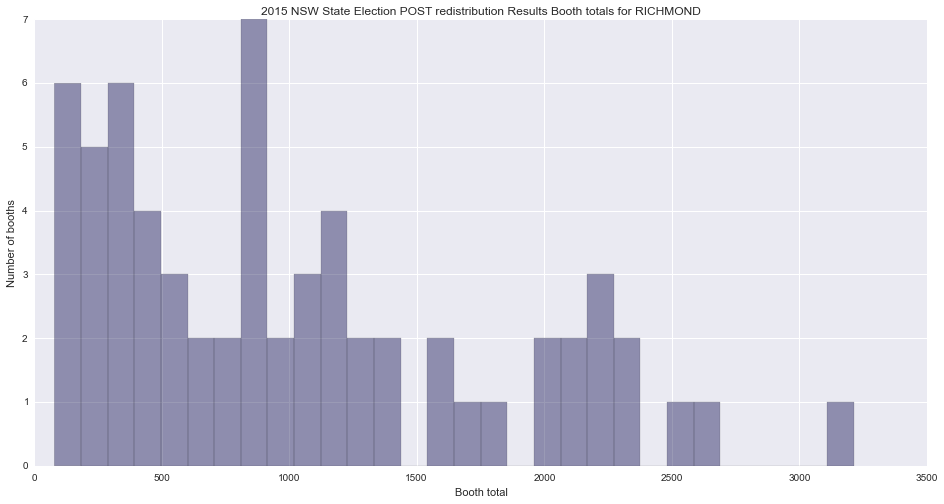

In [6]:
plt.figure(figsize=(16, 8))
sns.distplot(get_electorate_and_party(richmond_redist, 'Richmond', 'CLP', 'Booth total', True),
             bins=30, color=sns.xkcd_rgb["night blue"], label='Total Booth Vote', kde=False)

plt.xlabel('Booth total')
plt.ylabel('Number of booths')
plt.title('2015 NSW State Election POST redistribution Results Booth totals for RICHMOND')

** Figure 0 Distribution of booth total votes ** Most booths are less than 1000 total votes. There's a secondary peak at ~2.2k total votes.

# FP % VOTING DISTRIBUTIONS
---

To calculate FP% for any booth we use the equation:

$$ FP\,\% = \frac{FP\,Votes}{Total\,Booth\,Votes}$$

A FP % voting distribution is a measure of how the FP% for a party is spread out through an electorate. 

At risk of saying something completely obvious or intuitive let's clarify what a voting distribution is:
For party X, if a voting distribution is sharply peaked only at one value it means the FP% for party X is pretty much the same value throughout the whole electorate. On the otherhand, if a voting distribution has many peaks at different FP% values then the FP% for party X takes on many diffent values throughout the electorate.

This is worth internalizing because later on we will be looking at the differences in voting distributions as a result of the redistribution process. By doing so we can see whether redistribution helps or harms a party.

## FP% distribution for PRE redistribution

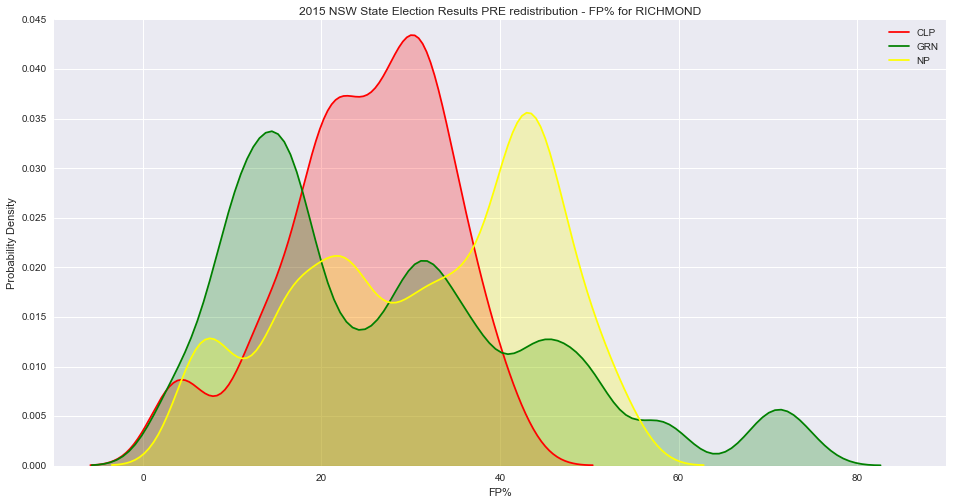

In [7]:
plt.figure(figsize=(16, 8))
sns.kdeplot(clp_predist, color='red', shade=True, bw=3.0, label='CLP')
sns.kdeplot(grn_predist, color='green', shade=True, bw=3.0, label='GRN')
sns.kdeplot(np_predist, color='yellow', shade=True, bw=3.0, label='NP')

plt.xlabel('FP%')
plt.ylabel('Probability Density')
plt.title('2015 NSW State Election Results PRE redistribution - FP% for RICHMOND')

**Figure 1: PRE redistribution FP %results:** All party distributions display a main peak in addition to having multiple smaller peaks. In statistics parlance, they are 'multimodal' distributions which means 'they're complicated'. No suprise there. The main peaks for the three parties inhabit distinct FP% regions indicating voter segmentation for the most popular FP% values. GRN have the most spread out distribution with quite a high FP% bump at ~70%. If you neglect this bump then eyeballing GRN and NP shows they're almost mirror images of each other - they're complementary: what works for one doesn't necessarily work for the other. The CLP distribution is more sharply peaked, is higher and contains noticebly less smaller bumps. The CLP voters are the most sharply defined segment.

The y-axis is showing 'Probability Density'. There's no real reason to understand this - just think that higher it is the more likely it is for a particular FP% to occur. Also please note that having FP% < 0 is physically unrealistic and is an artifact of the modelling process used, namely Kernel Density Estimation.

Now that we've qualitatively described the three distributions let's move onto the redistribution results.

## FP% distribution for POST redistribution

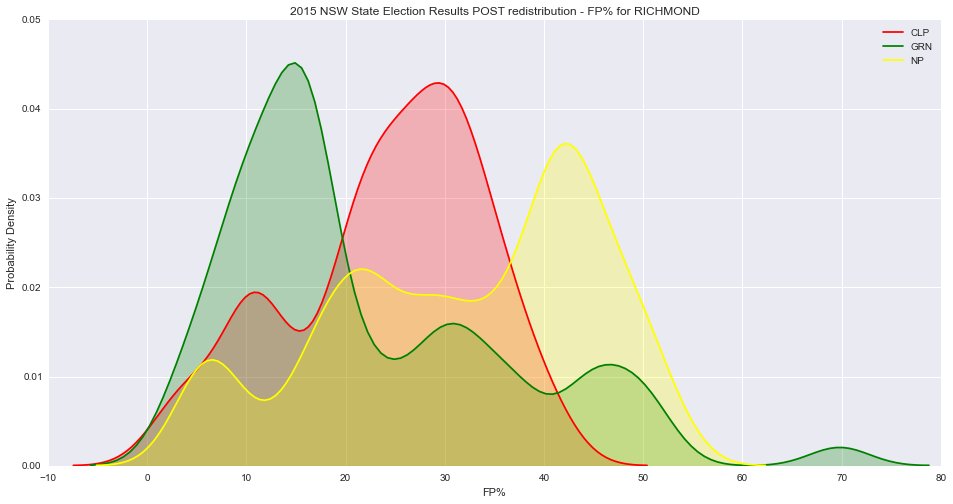

In [8]:
plt.figure(figsize=(16, 8))
sns.kdeplot(clp_redist, color='red', shade=True, bw=3.0, label='CLP')
sns.kdeplot(grn_redist, color='green', shade=True, bw=3.0, label='GRN')
sns.kdeplot(np_redist, color='yellow', shade=True, bw=3.0, label='NP')

plt.xlabel('FP%')
plt.ylabel('Probability Density')
plt.title('2015 NSW State Election Results POST redistribution - FP% for RICHMOND')

** Figure 2: POST redistribution FP% results: ** Again the three parties have distinct main FP% peaks with multiple smaller peaks. Perhaps the most notable thing is the GRN and CLP main peaks having roughly the same y-value - the main FP% for GRN and CLP are almost equally likely. The NP main peak has now become the lowest main peak.

Counting the number of peaks for each party reveals roughly one peak less as comparaed to the PRE redistribution results. In essence, the voting distributions have become smoother and the CLP distribution is even approaching that of the classic 'Bell Curve' shape. A Bell Curve or the more accurately named 'Normal distribution' is much easier to model. Besides that there's not much more we can say about it.

What's better is to plot the PRE and POST redistributions results on the same graph.

## Combined PRE and POST FP % distribution

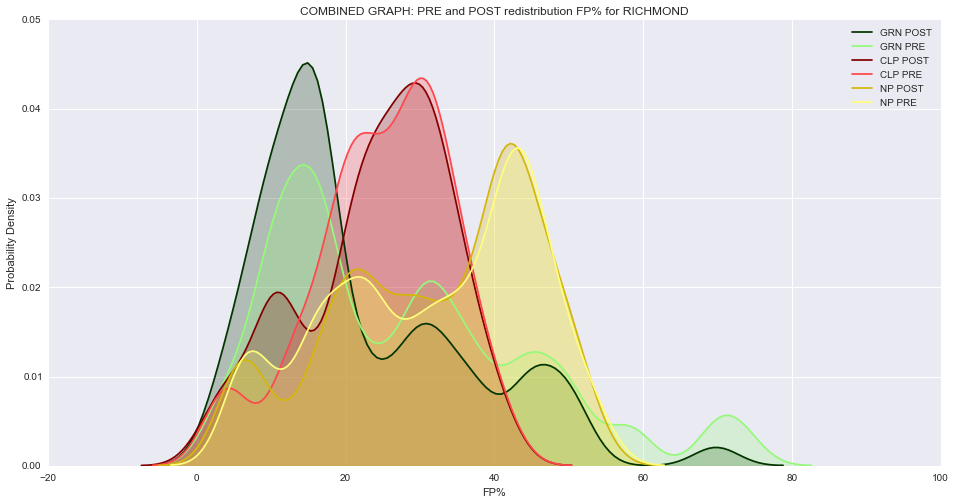

In [9]:
plt.figure(figsize=(16, 8))
ax_g_post = sns.kdeplot(grn_redist, color=sns.xkcd_rgb["dark green"], shade=True, bw=3.0, label='GRN POST')
ax_g_pre = sns.kdeplot(grn_predist, color=sns.xkcd_rgb["light green"], shade=True, bw=3.0, label='GRN PRE')
ax_l_post = sns.kdeplot(clp_redist, color=sns.xkcd_rgb["dark red"], shade=True, bw=3.0, label='CLP POST')
ax_l_pre = sns.kdeplot(clp_predist, color=sns.xkcd_rgb["light red"], shade=True, bw=3.0, label='CLP PRE')
ax_n_post = sns.kdeplot(np_redist, color=sns.xkcd_rgb["dark yellow"], shade=True, bw=3.0, label='NP POST')
ax_n_pre = sns.kdeplot(np_predist, color=sns.xkcd_rgb["light yellow"], shade=True, bw=3.0, label='NP PRE')

plt.xlabel('FP%')
plt.ylabel('Probability Density')
plt.title('COMBINED GRAPH: PRE and POST redistribution FP% for RICHMOND')


** Figure 3: Both PRE and POST redistribution FP% results: **

This graph is perhaps our best glimpse yet into how redistribution affects the parties.<br>

Here's a way to look at it: the area under each line must _always_ sum to one, so if there's more of a peak in one spot then the line must dip somewhere else . You can see this with the GRN party: POST redistribution grows a markedly larger peak at ~17%, and so must drop somewhere else, namely for most other higher FP% regions. This is almost a reason to raise alarm for the GRN party because it means redistribution reduces high GRN performing booths. But remember that we're talking about FP% here, which is calculated by $FP\% = FP\,Votes\,/\,Total\,Booth\,Votes$ and so if the high FP% booths being lost are very small then we're not really losing that much in terms of raw votes.

With that caveat said we can talk about some inferences.

* **CLP**: For both its PRE and POST lines it displays the best 'dual behaviour' out of all parties i.e. there's only 2 peaks. This means there's two distinct voting behaviours, one which is more likely (larger peak) and one which is less likely (smaller peak). And that's how you could explain the CLP vote to someone over the phone, say. Redistribution has pushed the lower smaller bump to the left of its main peak further right to become more prominent. That means that the dual voting behaviour of CLP is now more likely, with values of ~11% FP% and ~28%. Its main peak has become more defined.

* **NP**: There's a boost in the mid range FP% behaviour which is coming from the lowest trough/peak reducing. What this means is that it's now more likely for a FP% vote of ~23% and less likey for a ~16% FP% vote.

* **GRN**: All the lower peaks to the right of its main peak (~17%) have reduced and that loss is now contributing to the bolstering of its main peak, both higher and wider. This means it's more likely to have a GRN vote of ~17% and less likey to have higher FP% votes.

Focus on each party's main peak then look to the left and right of it. What can you see? 

Looking right, CLP and NP have no smaller bumps whereas GRN definitly does. Redistribution doesn't affect the CLP and NP distribtions to their right, _rather it is bringing up their lower bumps_. It's scooping lower peaks up into its larger peak, reinforcing the most likely larger peak FP% vote. The same behaviour is happening to GRN but in the _opposite_ direction - all of the smaller bumps to the right of its main peak are getting scooped up towards its lower FP% main peak.

That's redistribution when looked at through the FP% lense.

# RAW VOTES DISTRIBUTION
---

Let's look at the redistribution using raw vote numbers. This eliminates the aforementioned FP% caveat, is probably easier to grasp and at the end of the day it's all down to number of votes.

We will plot PRE and POST redistribution distributions separately, then together, then see if any new behaviour is observed.

>FP Raw Number just refers to the number of votes for a party at a booth

## FP Raw Number distribution for PRE redistribution

In [10]:
clp_redist_raw_votes = get_electorate_and_party(richmond_redist, 'Richmond', 'CLP', 'Final FP V', True)
clp_predist_raw_votes = get_electorate_and_party(richmond_predist, 'Richmond', 'CLP', 'Final FP V', False)
grn_redist_raw_votes = get_electorate_and_party(richmond_redist, 'Richmond', 'GRN', 'Final FP V', True)
grn_predist_raw_votes = get_electorate_and_party(richmond_predist, 'Richmond', 'GRN', 'Final FP V', False)
np_redist_raw_votes = get_electorate_and_party(richmond_redist, 'Richmond', 'NP', 'Final FP V', True)
np_predist_raw_votes = get_electorate_and_party(richmond_predist, 'Richmond', 'NP', 'Final FP V', False)


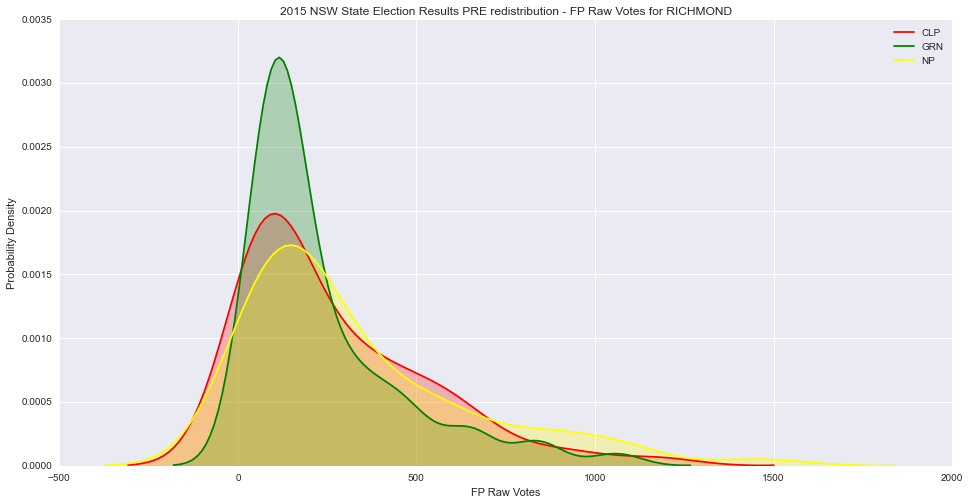

In [11]:
plt.figure(figsize=(16, 8))
sns.kdeplot(clp_predist_raw_votes, color='red', shade=True, label='CLP')
sns.kdeplot(grn_predist_raw_votes, color='green', shade=True, label='GRN')
sns.kdeplot(np_predist_raw_votes, color='yellow', shade=True, label='NP')

plt.xlabel('FP Raw Votes')
plt.ylabel('Probability Density')
plt.title('2015 NSW State Election Results PRE redistribution - FP Raw Votes for RICHMOND')

** Figure 4 PRE redistribution Raw Votes: ** All parties have their main peak low down on the FP Raw Votes axis which is a reflection of having many smaller booths (<500 total votes) and less larger booths in Richmond. Interestingly, the cluster of larger booths (~2.2k total votes) hasn't affected the results for the three parties. It could be a reflection of larger booths having more diverse voting, other than just CLP, GRN and NP votes dominating. This remains unchecked however and is largely speculatory.

NP has the most significant number of large votes, dominating in the upprt range of roughly 750 - 1250.

Also please note that having FP Raw Votes < 0 is physically unrealistic and is an artifact of the modelling process used, namely Kernel Density Estimation.

## FP Raw Number distribution for POST redistribution

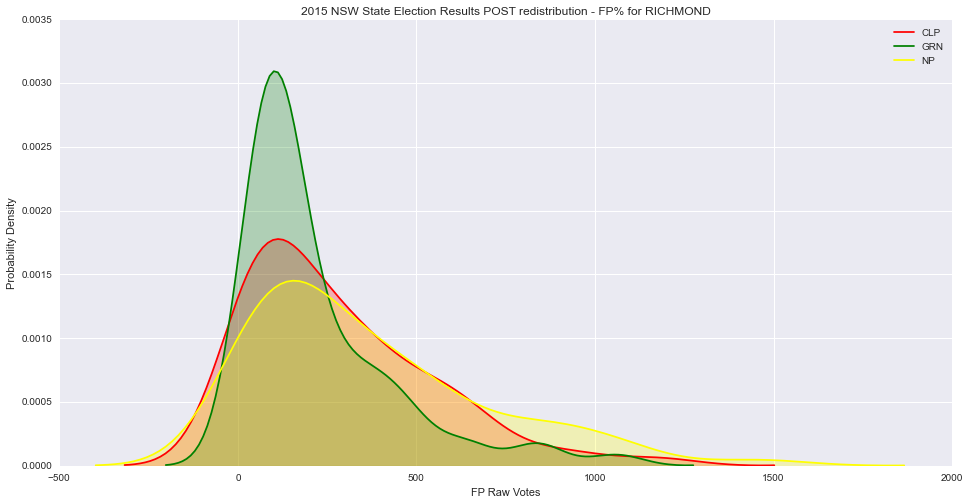

In [12]:
plt.figure(figsize=(16, 8))
sns.kdeplot(clp_redist_raw_votes, color='red', shade=True, label='CLP')
sns.kdeplot(grn_redist_raw_votes, color='green', shade=True, label='GRN')
sns.kdeplot(np_redist_raw_votes, color='yellow', shade=True, label='NP')

plt.xlabel('FP Raw Votes')
plt.ylabel('Probability Density')
plt.title('2015 NSW State Election Results POST redistribution - FP% for RICHMOND')

** Figure 5 POST redistribution Raw Votes: ** The dominating feature here is the branching away of both CLP and NP from GRN in the region roughly spanning the 250 - 750 total votes region. Redistribution has made the mid sized booths perform better for CLP and NP.

NP dominates where the mid sized booth range stops. From roughly 750 to 1200, NP dominates both GRN and CLP.

## Combined FP Raw Number PRE and POST distribution

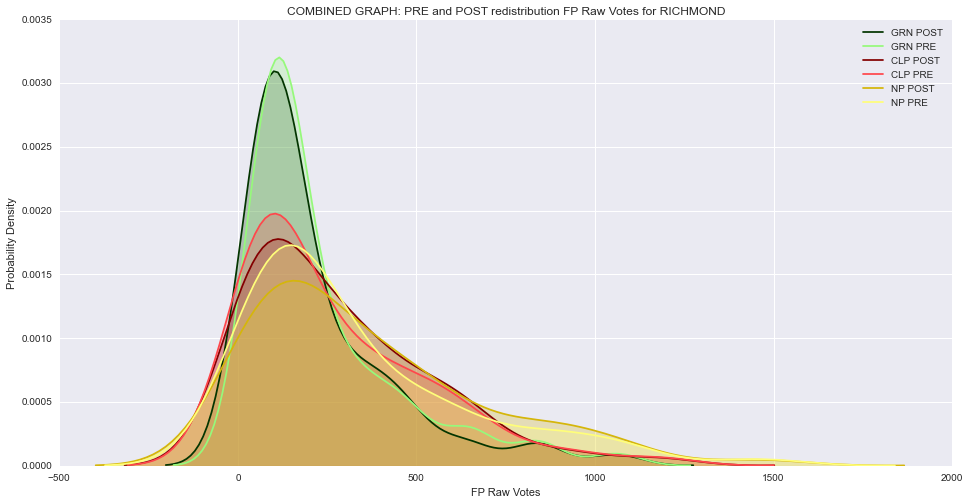

In [13]:
plt.figure(figsize=(16, 8))
ax_g_post = sns.kdeplot(grn_redist_raw_votes, color=sns.xkcd_rgb["dark green"], shade=True, label='GRN POST')
ax_g_pre = sns.kdeplot(grn_predist_raw_votes, color=sns.xkcd_rgb["light green"], shade=True, label='GRN PRE')
ax_l_post = sns.kdeplot(clp_redist_raw_votes, color=sns.xkcd_rgb["dark red"], shade=True, label='CLP POST')
ax_l_pre = sns.kdeplot(clp_predist_raw_votes, color=sns.xkcd_rgb["light red"], shade=True, label='CLP PRE')
ax_n_post = sns.kdeplot(np_redist_raw_votes, color=sns.xkcd_rgb["dark yellow"], shade=True, label='NP POST')
ax_n_pre = sns.kdeplot(np_predist_raw_votes, color=sns.xkcd_rgb["light yellow"], shade=True, label='NP PRE')

plt.xlabel('FP Raw Votes')
plt.ylabel('Probability Density')
plt.title('COMBINED GRAPH: PRE and POST redistribution FP Raw Votes for RICHMOND')


** Figure 6 PRE and POST redistribution Raw Votes: ** 

* CLP: The main peak has lowered and flattened, spreading out its FP Raw Vote probability towards the higher end of the spectrum. Votes of size 250 - 750 per booth more likely.

* NP: Like CLP, NP exhibits a flattening and lowering of its main peak. It has an increase of FP Raw Vote probability (and more than CLP receives) from 300 - 1000 votes. Redistribution has made it more likely for NP to get votes in this range from booths.

* GRN: Displays the least amount of change from redistribution. There's a slight increase in its main peak and subsequent translation to larger FP Raw Values. That's a good thing but compared to CLP and NP main peaks, it's the smallest change seen. A noticeable dip extending roughly from 550 - 700 FP Raw Votes means it's less likely that booths will produce GRN votes in that range.

# QUANTIFIED EFFECT OF REDISTRIBUTION
---

The main goal of this section is to quantify the effect of redistribution via our two metrics:

1. FP%
2. FP Raw Number

We're interested in plotting the differences in PRE and POST redistribution distributions for the two metrics and also in looking for a summary statistic - a single quantity that can describe the redistribution process. The summary statistics chosen here are:

1. Difference in mean FP%: $$\Delta\,FP\,\%\,mean\,=\,POST\,FP\%\,mean\,-\,PRE\,FP\%\,mean$$ 
2. Difference in sum of FP Raw Number: $$\Delta\,FP\,Raw\,Number\,= POST\,FP\,Raw\,Number\,-\,PRE\,FP\,Raw\,Number$$

>These will be calculated for each party.

## Effect on FP%

------------------------------
SUMMARY STATISTICS
------------------------------
Delta CLP FP % = -0.83%
Delta GRN FP % = -5.49%
Delta NP FP % = 0.33%


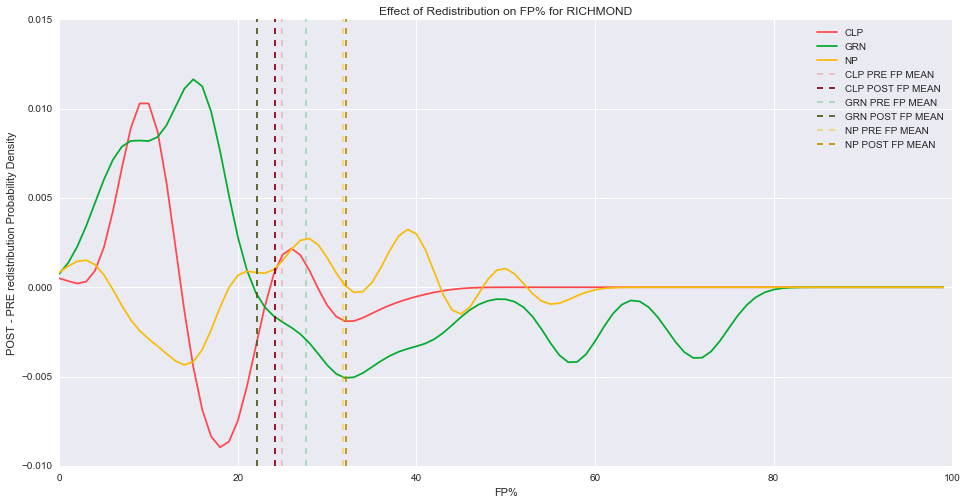

In [14]:
from sklearn.neighbors import KernelDensity


def kde_sklearn(x, x_grid, bandwidth=1.0, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(kernel='gaussian', bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


def plot_diff_in_kdes(post, pre, x_grid, party, bandwidth=3.0):
    colors = {'GRN': sns.xkcd_rgb["kelly green"],
              'CLP': sns.xkcd_rgb["light red"],
              'NP': sns.xkcd_rgb["golden rod"]}
    pdf_post = kde_sklearn(post.values, x_grid, bandwidth)
    pdf_pre = kde_sklearn(pre.values, x_grid, bandwidth)
    diff = pdf_post - pdf_pre
    plt.plot(diff, color=colors[party], label=party)
    

#define x values to evaluate fitted kde at.
x_grid = np.linspace(0, 100, 100)   

plt.figure(figsize=(16, 8))
plot_diff_in_kdes(clp_redist, clp_predist, x_grid, 'CLP')
plot_diff_in_kdes(grn_redist, grn_predist, x_grid, 'GRN')
plot_diff_in_kdes(np_redist, np_predist, x_grid, 'NP')


#draw vertical lines representing predist FP vote % means for PRE and POST Redist
plt.axvline(clp_predist.mean(), linestyle='--', color=sns.xkcd_rgb["light red"], alpha=0.3, label='CLP PRE FP MEAN')
plt.axvline(clp_redist.mean(), linestyle='--', color=sns.xkcd_rgb["crimson"], alpha=1.0, label='CLP POST FP MEAN')
plt.axvline(grn_predist.mean(), linestyle='--', color=sns.xkcd_rgb["kelly green"], alpha=0.3, label='GRN PRE FP MEAN')
plt.axvline(grn_redist.mean(), linestyle='--', color=sns.xkcd_rgb["army green"], alpha=1.0, label='GRN POST FP MEAN')
plt.axvline(np_predist.mean(), linestyle='--', color=sns.xkcd_rgb["golden rod"], alpha=0.5, label='NP PRE FP MEAN')
plt.axvline(np_redist.mean(), linestyle='--', color=sns.xkcd_rgb["ochre"], alpha=1.0, label='NP POST FP MEAN')

plt.title('Effect of Redistribution on FP% for RICHMOND')
plt.xlabel('FP%')
plt.ylabel('POST - PRE redistribution Probability Density')
plt.legend()

print 30 * "-"
print "SUMMARY STATISTICS"
print 30 * "-"
print "Delta CLP FP % = {0:.2f}%".format(clp_redist.mean() - clp_predist.mean())
print "Delta GRN FP % = {0:.2f}%".format(grn_redist.mean() - grn_predist.mean())
print "Delta NP FP % = {0:.2f}%".format(np_redist.mean() - np_predist.mean())

** Figure 7 Redistribution Effect: Change in FP% for each party: ** The solid lines are the difference between POST and PRE FP% distributions, and the dotted lines are our summary statistics for each party, both POST and PRE.

If at a particular point the line is positive it means there's more FP% after redistribtion. Conversely, if it's negative it means there's less FP% at that particular point.


* CLP sees an increase of FP% in ranges 4 - 13 FP% and 24 - 28 FP%. There's also a decrease from 14 - 23 FP% and 28 - 43 %.

* GRN benefits in the range 0 - 21 FP% and loses out in range 22 - 80%. Since there's more booths having less total votes it means GRN will get more votes from smaller booths.

* NP sees its largest decrease in the lower end, from 5 - 19 FP%, then twice again at 43 - 48 FP%% and 52 - 60 FP%. From 19 - 43 FP%

The summary statistics are easily interpreted: for a particular party if the dotted POST line is greater than its corresponding dotted PRE line then redistribution **increases** the mean FP%. And vice-versa.


| Party | Summary Statistic: $$\Delta FP\%\,mean$$ |
| ------ | ----------- |
| CLP | -0.83% |
| GRN | -5.49% |
| NP  | +0.33% |

## Effect on FP Raw Number

------------------------------
SUMMARY STATISTICS
------------------------------
Delta CLP FP Raw Number = 1554.0
Delta GRN FP Raw Number = -370.5
Delta NP FP Raw Number = 3007.5


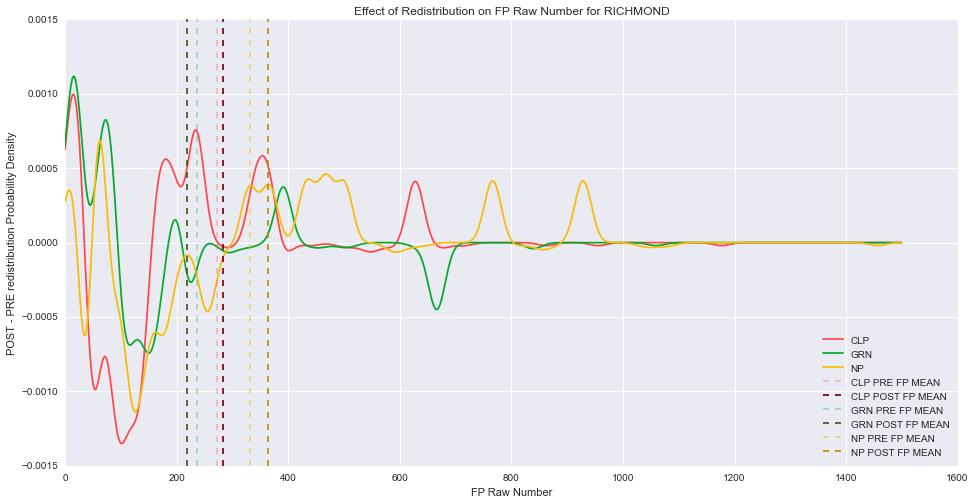

In [15]:
x_grid_raw_votes = np.linspace(0,1500,1500)

plt.figure(figsize=(16, 8))
plot_diff_in_kdes(clp_redist_raw_votes, clp_predist_raw_votes, x_grid_raw_votes, 'CLP', bandwidth=15.0)
plot_diff_in_kdes(grn_redist_raw_votes, grn_predist_raw_votes, x_grid_raw_votes, 'GRN', bandwidth=15.0)
plot_diff_in_kdes(np_redist_raw_votes, np_predist_raw_votes, x_grid_raw_votes, 'NP', bandwidth=15.0)


#draw vertical lines representing predist FP vote % means for PRE and POST Redist
plt.axvline(clp_predist_raw_votes.mean(), linestyle='--', color=sns.xkcd_rgb["light red"], alpha=0.3,
            label='CLP PRE FP MEAN')
plt.axvline(clp_redist_raw_votes.mean(), linestyle='--', color=sns.xkcd_rgb["crimson"], alpha=1.0,
            label='CLP POST FP MEAN')
plt.axvline(grn_predist_raw_votes.mean(), linestyle='--', color=sns.xkcd_rgb["kelly green"], alpha=0.3,
            label='GRN PRE FP MEAN')
plt.axvline(grn_redist_raw_votes.mean(), linestyle='--', color=sns.xkcd_rgb["army green"], alpha=1.0,
            label='GRN POST FP MEAN')
plt.axvline(np_predist_raw_votes.mean(), linestyle='--', color=sns.xkcd_rgb["golden rod"], alpha=0.5,
            label='NP PRE FP MEAN')
plt.axvline(np_redist_raw_votes.mean(), linestyle='--', color=sns.xkcd_rgb["ochre"], alpha=1.0,
            label='NP POST FP MEAN')

plt.title('Effect of Redistribution on FP Raw Number for RICHMOND')
plt.xlabel('FP Raw Number')
plt.ylabel('POST - PRE redistribution Probability Density')
plt.legend(loc=4)

print 30 * "-"
print "SUMMARY STATISTICS"
print 30 * "-"
print "Delta CLP FP Raw Number = {0:.1f}".format(clp_redist_raw_votes.sum() - clp_predist_raw_votes.sum())
print "Delta GRN FP Raw Number = {0:.1f}".format(grn_redist_raw_votes.sum() - grn_predist_raw_votes.sum())
print "Delta NP FP Raw Number = {0:.1f}".format(np_redist_raw_votes.sum() - np_predist_raw_votes.sum())

** Figure 8 Redistribution Effect: Change in FP Raw Number for each party: ** The solid lines are the difference between POST and PRE FP Raw Number votes distributions, and the dotted lines are our summary statistics for each party, both POST and PRE.

If at a particular point the line is positive it means there's more FP Raw Number votes after redistribtion. Conversely, if it's negative it means there's less FP Raw Number votes at that particular point.


| Party | Summary Statistic: $\Delta FP\,Raw\,Number\,Sum$ |
| ------ | --- |
| CLP | +1554.0 |
| GRN | -370.5 |
| NP  | +3007.5 |

CLP and NP are gaining 1554 and 3007 raw votes respectively, whilst GRN is losing 370 votes from redistribution.

# CORRELATIONS - BONUS ROUND
---

As a quick additional calculation let's look at how the FP% behaves wrt Latitude, Longitude and Booth size.

## Correlation of Longitude, Latitude and Booth Size on FP% 

Determine the correlation of FP% with:

1. Latitude
2. Longitude
3. Booth size

------------------------------
CORRELATION: CLP
------------------------------
                    Perc of total vote  Longitude  Latitude  Booth total
Perc of total vote                1.00       0.25      0.27         0.38
Longitude                         0.25       1.00      0.74         0.41
Latitude                          0.27       0.74      1.00         0.26
Booth total                       0.38       0.41      0.26         1.00


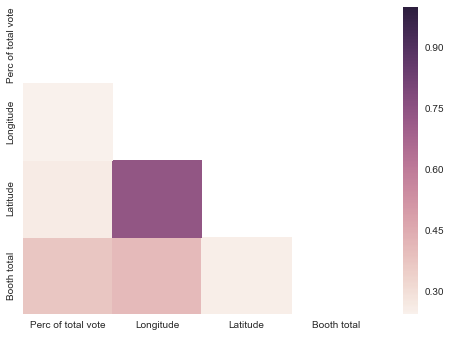

------------------------------
CORRELATION: GRN
------------------------------
                    Perc of total vote  Longitude  Latitude  Booth total
Perc of total vote                1.00       0.17      0.11        -0.07
Longitude                         0.17       1.00      0.74         0.41
Latitude                          0.11       0.74      1.00         0.26
Booth total                      -0.07       0.41      0.26         1.00


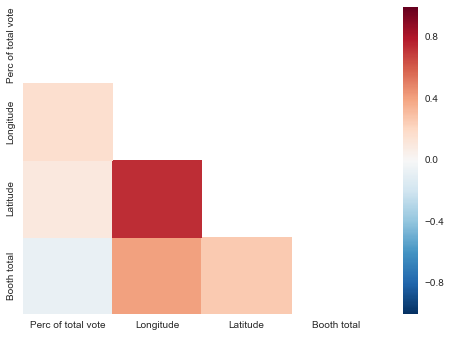

------------------------------
CORRELATION: NP
------------------------------
                    Perc of total vote  Longitude  Latitude  Booth total
Perc of total vote                1.00      -0.08      0.26        -0.03
Longitude                        -0.08       1.00      0.74         0.41
Latitude                          0.26       0.74      1.00         0.26
Booth total                      -0.03       0.41      0.26         1.00


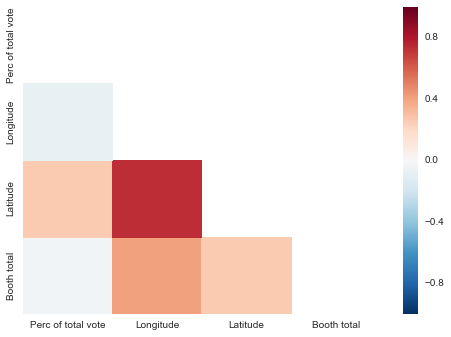

In [16]:
def corr_and_heatmap(party):
    
    #rid the dark background
    sns.set(style="white")
    
    #calc correlations
    corr = (richmond_redist.loc[richmond_redist['Party Acro'] == party, 
                               ['Perc of total vote',
                                'Longitude', 
                                'Latitude', 
                                'Booth total']]
                           .corr())
    
    #generate a mask for the upper triangle - don't want to show redundant info in upper triangle of matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    #plot corr table
    print 30 * "-"
    print "CORRELATION: {0}".format(party)
    print 30 * "-" 
    print corr
    
    #plt heatmap
    sns.heatmap(corr, mask=mask)
    plt.show()
    
corr_and_heatmap('CLP')
corr_and_heatmap('GRN')
corr_and_heatmap('NP')

#set plotting style back to like before
sns.set()

** Figure 9 Correlation Plots for CLP, GRN and NP respectively: **

If two quantities have a correlation value of 1 it means that whenever one quantity increases so does the other, in perfect synchrony. As the correlation value reduces towards 0, the two quantities are less correlated and they don't always increase together - sometimes one quantity will increase whilst the other one doesn't. If correlation becomes negative, it means the two quantities move in the opposite direction to one another - an increase in one sees a decrease in the other.

When looking at these results please take into account the assumption made in this study. Namely, how we determined boundary booths and arbitrarily assigned half the votes to electorates either side of the boundary.

The correlation between Booth total and FP% for each party is:
* CLP = +0.38
* GRN = -0.07
* NP = -0.03

CLP FP% is the most highly correlated with Booth total, whilst GRN and NP FP% are not so much correlated with Booth size.

The correlation between Latitude and FP% for each party is:
* CLP = +0.27
* GRN = +0.11
* NP = +0.26

As Latitude increases i.e. you move North, CLP and NP FP% increases with similar correlation strength. GRN FP% also increases but its correlation is roughly a third strong.

The correlation between Longitude and FP% for each party is:
* CLP = +0.25
* GRN = +0.17
* NP = -0.08

As Longitude increases i.e. you move East, CLP and GRN FP% increases whilst NP FP% displays little correlation.

# BIBLIOGRAPHY
---


#### [0]: http://www.aec.gov.au/electorates/Redistributions/
#### [1]: http://vtr.elections.nsw.gov.au/SGE2015/la-home.htm and download 'State-wide FP Spreadsheet by Venue and Candidate'
#### [2]: http://www.aec.gov.au/media/media-releases/2015/10-16.htm
#### [3]: http://www.aec.gov.au/Electorates/Redistributions/2014/nsw/proposed-report/
#### [4]: http://www.aec.gov.au/Electorates/Redistributions/2014/nsw/proposed-report/maps/index.htm

